In [38]:
from Autoencoder import *
from make_video import *

import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer,Conv2D,MaxPool2D,\
UpSampling2D,Conv2DTranspose,Cropping2D,Add,add
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*4))])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Parameters

In [2]:
## For Current PC
# DATASET = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Dataset' ## where there is dataset
# DATASET_NAME = r'bunny_video.mp4' ## Name of the video
# FRAMES = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\Video_Frames' ## where you want to save the frames
# RECONSTRUCTED = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\ReconVideo_Frames' ## where the reconstructed frames are saved

## For NAON PC
DATASET = r'C:\Users\saad\Desktop\Autoencoders\Videos\Dataset' ## where there is dataset
DATASET_NAME = r'bunny_video.mp4' ## Name of the video
FRAMES = r'C:\Users\saad\Desktop\Autoencoders\Videos\Results\Video_Frames' ## where you want to save the frames
RECONSTRUCTED = r'C:\Users\saad\Desktop\Autoencoders\Videos\Results\ReconVideo_Frames' ## where the reconstructed frames are saved

## initial w,h are 640,480
WIDTH = 320 ## width of the reconstrcted image
HEIGHT = 240 ## height of the reconstrcted image
FPS = 25 ## fps of the reconstrcted image
SLICES = 2 ## Number of slices to be made on the image

EMBEDDING_SIZE = 512 ## bottleneck layer nodes

Loading Video...
Completed
The fps is 25.0, The width of the frame is 1280 and the height of the frame is 720
(1478, 240, 160, 3)


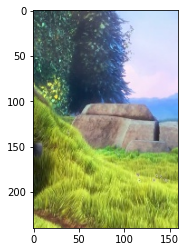

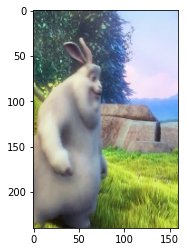

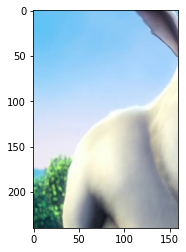

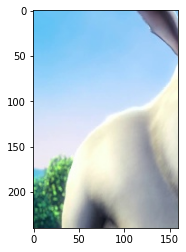

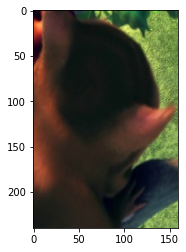

In [3]:
names,fps,width,height = read_video(FRAMES,os.path.join(DATASET,DATASET_NAME))

print(f'The fps is {fps}, The width of the frame is {width} and the height of the frame is {height}')

images1 = np.array(read_imgs(FRAMES,names,SLICES,WIDTH,HEIGHT))
print(images1.shape)
images = images1.astype('float32')/255.

## Sanity check on the images
ran = random.sample(range(0,len(images)),5)
for r in ran:
    plt.imshow(images[r])
    plt.show()

In [4]:
images.shape

(1478, 240, 160, 3)

In [5]:
train,test = splitter(images,0.1)
print(f'The shape of train is {train.shape}')
print(f'The shape of test is {test.shape}')

The shape of train is (1330, 240, 160, 3)
The shape of test is (148, 240, 160, 3)


In [ ]:
## SSIM = 0.94
# The encoder
encoder = Sequential()
encoder.add(InputLayer((480,320,3)))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))

# The decoder
decoder = Sequential()
decoder.add(InputLayer((30,20,32)))
decoder.add(Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same'))

In [ ]:
## Residual Autoencoder - Take 1
# SSIM = 0.99

# The encoder
encoder_1 = Input((480,320,3),name='encoder_input')
encoder_2 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='ELayer1')(encoder_1)
encoder_3 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='ELayer2')(encoder_2)
encoder_4 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='ELayer3')(encoder_3)
encoder_5 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='ELayer4')(encoder_4)

# encoder = Model(encoder_1,encoder_5)

# The decoder
# decoder_1 = Input((30,20,32),name='decoder_input')
decoder_2 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='DLayer1')(encoder_5)
add_1 = add([decoder_2,encoder_4]) # Residual Network
decoder_3 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='DLayer2')(add_1)
decoder_4 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='DLayer3')(decoder_3)
add_2 = add([decoder_4,encoder_2]) # Residual Network
decoder_5 = Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same',name='DLayer4')(add_2)

autoencoder = Model(encoder_1,decoder_5)

autoencoder.compile(optimizer='adam',loss='mse',metrics=['mae'])
autoencoder.summary()

In [6]:
## Hi-res Autoencoders - Take 1

##################################
####### First Autoencoder ########
##################################

# The encoder 1
encoder1_1 = Input((480,320,3),name='encoder1_input')
encoder1_2 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer1')(encoder1_1)
encoder1_3 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer2')(encoder1_2)
encoder1_4 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer3')(encoder1_3)
encoder1_5 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer4')(encoder1_4)

encoder1 = Model(encoder1_1,encoder1_5)

# The decoder 1
decoder1_1 = Input((30,20,32),name='decoder1_input')
decoder1_2 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer1')(decoder1_1)
decoder1_3 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer2')(decoder1_2)
decoder1_4 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer3')(decoder1_3)
decoder1_5 = Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same',name='D1Layer4')(decoder1_4)

decoder1 = Model(decoder1_1,decoder1_5)

inp = Input((480,320,3))
code = encoder1(inp)
reconstruction = decoder1(code)
autoencoder1 = Model(inp,reconstruction)

##################################
####### Second Autoencoder #######
##################################

# The encoder 2
encoder2_1 = autoencoder1.output #Input((480,320,3),name='encoder2_input')
encoder2_2 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E2Layer1')(encoder2_1)
encoder2_3 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E2Layer2')(encoder2_2)
encoder2_4 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E2Layer3')(encoder2_3)
encoder2_5 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E2Layer4')(encoder2_4)

# The decoder 2
decoder2_2 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D2Layer1')(encoder2_5)
add2_1 = add([decoder2_2,encoder2_4]) # Residual Connection 
decoder2_3 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D2Layer2')(add2_1)
decoder2_4 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D2Layer3')(decoder2_3)
add2_2 = add([decoder2_4,encoder2_2]) # Residual Connection 
decoder2_5 = Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same',name='D2Layer4')(add2_2)

# autoencoder2 = Model(encoder2_1,decoder2_5)

autoencoder = Model(autoencoder1.input,decoder2_5)

# autoencoder.compile(optimizer='adam',loss='mse',metrics=['mae'])
# autoencoder.summary()

In [43]:
## Hi-res Autoencoders - Take 2

##################################
####### First Autoencoder ########
##################################

# The encoder 1
encoder1_1 = Input((240,160,3),name='encoder1_input')
encoder1_2 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer1')(encoder1_1)
encoder1_3 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer2')(encoder1_2)
encoder1_4 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer3')(encoder1_3)
encoder1_5 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer4')(encoder1_4)

encoder1 = Model(encoder1_1,encoder1_5)

# The decoder 1
decoder1_1 = Input((15,10,32),name='decoder1_input')
decoder1_2 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer1')(decoder1_1)
decoder1_3 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer2')(decoder1_2)
decoder1_4 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer3')(decoder1_3)
decoder1_5 = Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same',name='D1Layer4')(decoder1_4)

decoder1 = Model(decoder1_1,decoder1_5)

inp = Input((240,160,3))
code = encoder1(inp)
reconstruction = decoder1(code)
autoencoder1 = Model(inp,reconstruction)

##################################
####### Second Autoencoder #######
##################################

# The encoder 2
encoder2_1 = Input((240,160,3),name='encoder2_input')
encoder2_2 = Conv2D(filters=256,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='E2Layer1')(encoder2_1)
encoder2_3 = Conv2D(filters=128,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='E2Layer2')(encoder2_2)
encoder2_4 = Conv2D(filters=64,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='E2Layer3')(encoder2_3)
encoder2_5 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='E2Layer4')(encoder2_4)

# The decoder 2
decoder2_2 = Conv2DTranspose(filters=64,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='D2Layer1')(encoder2_5)
add2_1 = add([decoder2_2,encoder2_4]) # Residual Connection 
decoder2_3 = Conv2DTranspose(filters=128,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='D2Layer2')(add2_1)
decoder2_4 = Conv2DTranspose(filters=256,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='D2Layer3')(decoder2_3)
add2_2 = add([decoder2_4,encoder2_2]) # Residual Connection 
decoder2_5 = Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='D2Layer4')(add2_2)

autoencoder2 = Model(encoder2_1,decoder2_5)

# autoencoder = Model(autoencoder1.input,decoder2_5)

# autoencoder.compile(optimizer='adam',loss='mse',metrics=['mae'])
# autoencoder.summary()

In [44]:
encoder1.summary(), decoder1.summary()

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder1_input (InputLayer)  [(None, 240, 160, 3)]     0         
_________________________________________________________________
E1Layer1 (Conv2D)            (None, 120, 80, 32)       896       
_________________________________________________________________
E1Layer2 (Conv2D)            (None, 60, 40, 32)        9248      
_________________________________________________________________
E1Layer3 (Conv2D)            (None, 30, 20, 32)        9248      
_________________________________________________________________
E1Layer4 (Conv2D)            (None, 15, 10, 32)        9248      
Total params: 28,640
Trainable params: 28,640
Non-trainable params: 0
_________________________________________________________________
Model: "functional_51"
_________________________________________________________________
Layer (type)              

(None, None)

In [45]:
autoencoder2.summary()

Model: "functional_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder2_input (InputLayer)     [(None, 240, 160, 3) 0                                            
__________________________________________________________________________________________________
E2Layer1 (Conv2D)               (None, 120, 80, 256) 7168        encoder2_input[0][0]             
__________________________________________________________________________________________________
E2Layer2 (Conv2D)               (None, 60, 40, 128)  295040      E2Layer1[0][0]                   
__________________________________________________________________________________________________
E2Layer3 (Conv2D)               (None, 30, 20, 64)   73792       E2Layer2[0][0]                   
______________________________________________________________________________________

In [47]:
autoencoder2.compile(loss='mse',optimizer='adam',metrics=['mae'])
filepath2 = 'weights_combo2.hdf5'
checkpoint2 = ModelCheckpoint(filepath2,monitor='val_loss',verbose=0,save_best_only=True,mode=min)

Epoch 1/200
240/240 [==============================] - 2s 8ms/step - loss: 0.0304 - mae: 0.1123 - val_loss: 0.0112 - val_mae: 0.0816
Epoch 2/200
240/240 [==============================] - 2s 6ms/step - loss: 0.0064 - mae: 0.0550 - val_loss: 0.0055 - val_mae: 0.0502
Epoch 3/200
240/240 [==============================] - 2s 6ms/step - loss: 0.0054 - mae: 0.0511 - val_loss: 0.0047 - val_mae: 0.0466
Epoch 4/200
240/240 [==============================] - 2s 6ms/step - loss: 0.0045 - mae: 0.0464 - val_loss: 0.0043 - val_mae: 0.0452
Epoch 5/200
240/240 [==============================] - 2s 6ms/step - loss: 0.0037 - mae: 0.0400 - val_loss: 0.0033 - val_mae: 0.0368
Epoch 6/200
240/240 [==============================] - 2s 6ms/step - loss: 0.0034 - mae: 0.0381 - val_loss: 0.0031 - val_mae: 0.0351
Epoch 7/200
240/240 [==============================] - 2s 6ms/step - loss: 0.0035 - mae: 0.0389 - val_loss: 0.0029 - val_mae: 0.0335
Epoch 8/200
240/240 [==============================] - 1s 6ms/step - 

Epoch 61/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0016 - mae: 0.0251 - val_loss: 0.0017 - val_mae: 0.0257
Epoch 62/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0016 - mae: 0.0244 - val_loss: 0.0016 - val_mae: 0.0240
Epoch 63/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0016 - mae: 0.0236 - val_loss: 0.0016 - val_mae: 0.0243
Epoch 64/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0016 - mae: 0.0241 - val_loss: 0.0016 - val_mae: 0.0257
Epoch 65/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0021 - mae: 0.0308 - val_loss: 0.0017 - val_mae: 0.0254
Epoch 66/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0016 - mae: 0.0240 - val_loss: 0.0016 - val_mae: 0.0248
Epoch 67/200
240/240 [==============================] - 2s 6ms/step - loss: 0.0016 - mae: 0.0244 - val_loss: 0.0016 - val_mae: 0.0237
Epoch 68/200
240/240 [==============================] - 2s 6ms

Epoch 122/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0015 - mae: 0.0234 - val_loss: 0.0015 - val_mae: 0.0237
Epoch 123/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0015 - mae: 0.0235 - val_loss: 0.0015 - val_mae: 0.0240
Epoch 124/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0016 - mae: 0.0254 - val_loss: 0.0015 - val_mae: 0.0239
Epoch 125/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0015 - mae: 0.0235 - val_loss: 0.0015 - val_mae: 0.0236
Epoch 126/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0015 - mae: 0.0234 - val_loss: 0.0015 - val_mae: 0.0237
Epoch 127/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0015 - mae: 0.0238 - val_loss: 0.0016 - val_mae: 0.0245
Epoch 128/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0016 - mae: 0.0250 - val_loss: 0.0015 - val_mae: 0.0237
Epoch 129/200
240/240 [==============================] 

240/240 [==============================] - 1s 6ms/step - loss: 0.0015 - mae: 0.0235 - val_loss: 0.0015 - val_mae: 0.0237
Epoch 183/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0015 - mae: 0.0243 - val_loss: 0.0015 - val_mae: 0.0244
Epoch 184/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0015 - mae: 0.0234 - val_loss: 0.0015 - val_mae: 0.0237
Epoch 185/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0016 - mae: 0.0256 - val_loss: 0.0015 - val_mae: 0.0236
Epoch 186/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0015 - mae: 0.0233 - val_loss: 0.0015 - val_mae: 0.0236
Epoch 187/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0015 - mae: 0.0234 - val_loss: 0.0015 - val_mae: 0.0236
Epoch 188/200
240/240 [==============================] - 1s 6ms/step - loss: 0.0016 - mae: 0.0248 - val_loss: 0.0015 - val_mae: 0.0236
Epoch 189/200
240/240 [==============================] - 1s 6ms/step 

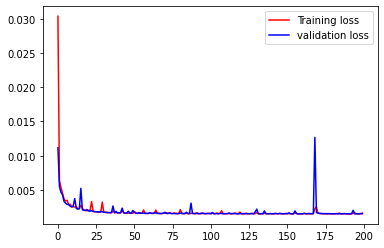

In [15]:
autoencoder1.compile(loss='mse',optimizer='adam',metrics=['mae'])
# autoencoder2.compile(loss='mse',optimizer='adam',metrics=['mae'])

filepath1 = 'weights_combo1.hdf5'
checkpoint1 = ModelCheckpoint(filepath1,monitor='val_loss',verbose=0,save_best_only=True,mode=min)

filepath2 = 'weights_combo2.hdf5'
checkpoint2 = ModelCheckpoint(filepath2,monitor='val_loss',verbose=0,save_best_only=True,mode=min)

history1 = autoencoder1.fit(train,train,epochs=200,batch_size=5,validation_split=0.1,callbacks=[checkpoint1])

plt.plot(history1.history['loss'],'r',label='Training loss')
plt.plot(history1.history['val_loss'],'b',label='validation loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


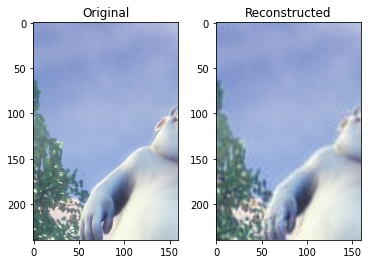

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------ 0.9408721950804876


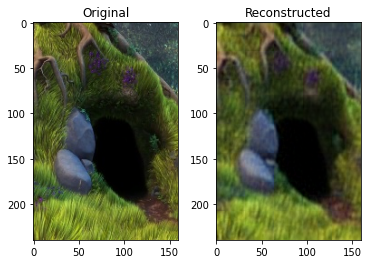

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------ 0.783930419829327


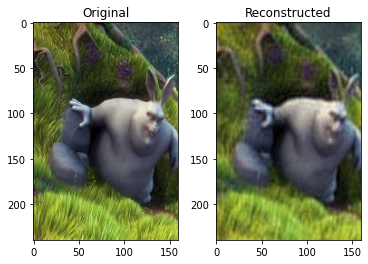

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------ 0.7752682814618164


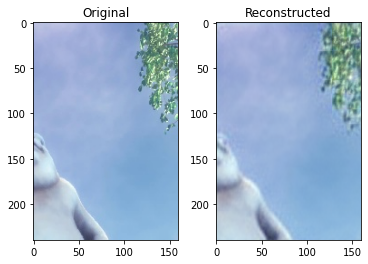

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------ 0.9543144590776478


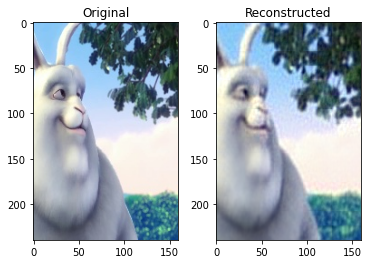

------------------------------ 0.9153412139379234


In [16]:
autoencoder1.load_weights(filepath1)

num = random.sample(range(0,len(train)),5)

for i in num:
    im = train[i]
    pred=autoencoder1.predict(np.expand_dims(im,axis=0))
    plt.subplot(121)
    plt.imshow(im)
    plt.title('Original')
    
    plt.subplot(122)
    plt.imshow(pred[0,:,:,:])
    plt.title('Reconstructed')
    
    plt.show()
    
    print('-'*30,overall_ssim(train[i],pred[0,:,:,:]))

In [21]:
import gc
train_intermediate = []
for i in range(len(train)):
    if i%5 == 0:
        print(i)
    imgs_new = np.expand_dims(train[i],axis=0)
    t=autoencoder1.predict(imgs_new)
    train_intermediate.append(t)
    del(t)
    del(imgs_new)
    gc.collect()
    
train_intermediate=np.array(train_intermediate)
train_intermediate=train_intermediate.reshape(train_intermediate.shape[0],train_intermediate.shape[2],
                                              train_intermediate.shape[3],train_intermediate.shape[4])

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
12

In [22]:
train_intermediate.shape

(1330, 240, 160, 3)

In [23]:
train.shape

(1330, 240, 160, 3)

In [24]:
overall_ssim(train,train_intermediate)

0.8933574187835761

Epoch 1/200
240/240 [==============================] - 5s 21ms/step - loss: 0.0136 - mae: 0.0588 - val_loss: 0.0020 - val_mae: 0.0250
Epoch 2/200
240/240 [==============================] - 5s 20ms/step - loss: 0.0019 - mae: 0.0238 - val_loss: 0.0018 - val_mae: 0.0236
Epoch 3/200
240/240 [==============================] - 5s 19ms/step - loss: 0.0018 - mae: 0.0231 - val_loss: 0.0018 - val_mae: 0.0233
Epoch 4/200
240/240 [==============================] - 5s 19ms/step - loss: 0.0017 - mae: 0.0227 - val_loss: 0.0017 - val_mae: 0.0230
Epoch 5/200
240/240 [==============================] - 5s 19ms/step - loss: 0.0016 - mae: 0.0225 - val_loss: 0.0016 - val_mae: 0.0226
Epoch 6/200
240/240 [==============================] - 5s 19ms/step - loss: 0.0016 - mae: 0.0223 - val_loss: 0.0016 - val_mae: 0.0223
Epoch 7/200
240/240 [==============================] - 5s 19ms/step - loss: 0.0015 - mae: 0.0221 - val_loss: 0.0019 - val_mae: 0.0301
Epoch 8/200
240/240 [==============================] - 5s 20ms

240/240 [==============================] - 5s 19ms/step - loss: 6.7328e-04 - mae: 0.0148 - val_loss: 6.9977e-04 - val_mae: 0.0149
Epoch 60/200
240/240 [==============================] - 5s 19ms/step - loss: 6.7933e-04 - mae: 0.0151 - val_loss: 7.1538e-04 - val_mae: 0.0152
Epoch 61/200
240/240 [==============================] - 5s 19ms/step - loss: 6.6682e-04 - mae: 0.0147 - val_loss: 6.8655e-04 - val_mae: 0.0148
Epoch 62/200
240/240 [==============================] - 5s 19ms/step - loss: 6.5671e-04 - mae: 0.0145 - val_loss: 6.9545e-04 - val_mae: 0.0150
Epoch 63/200
240/240 [==============================] - 5s 19ms/step - loss: 6.6720e-04 - mae: 0.0149 - val_loss: 6.8243e-04 - val_mae: 0.0147
Epoch 64/200
240/240 [==============================] - 5s 19ms/step - loss: 6.5182e-04 - mae: 0.0145 - val_loss: 6.8256e-04 - val_mae: 0.0147
Epoch 65/200
240/240 [==============================] - 5s 19ms/step - loss: 6.4839e-04 - mae: 0.0145 - val_loss: 6.8252e-04 - val_mae: 0.0149
Epoch 66/200

240/240 [==============================] - 5s 19ms/step - loss: 5.8219e-04 - mae: 0.0138 - val_loss: 6.2141e-04 - val_mae: 0.0140
Epoch 117/200
240/240 [==============================] - 5s 19ms/step - loss: 5.9175e-04 - mae: 0.0140 - val_loss: 6.4146e-04 - val_mae: 0.0144
Epoch 118/200
240/240 [==============================] - 5s 19ms/step - loss: 5.8449e-04 - mae: 0.0138 - val_loss: 6.2670e-04 - val_mae: 0.0142
Epoch 119/200
240/240 [==============================] - 5s 19ms/step - loss: 5.9824e-04 - mae: 0.0142 - val_loss: 6.2524e-04 - val_mae: 0.0141
Epoch 120/200
240/240 [==============================] - 5s 19ms/step - loss: 5.7393e-04 - mae: 0.0136 - val_loss: 6.2653e-04 - val_mae: 0.0141
Epoch 121/200
240/240 [==============================] - 5s 19ms/step - loss: 5.7642e-04 - mae: 0.0137 - val_loss: 6.2114e-04 - val_mae: 0.0140
Epoch 122/200
240/240 [==============================] - 5s 19ms/step - loss: 5.7664e-04 - mae: 0.0137 - val_loss: 6.2731e-04 - val_mae: 0.0142
Epoch 

Epoch 173/200
240/240 [==============================] - 5s 19ms/step - loss: 5.7151e-04 - mae: 0.0140 - val_loss: 6.0542e-04 - val_mae: 0.0138
Epoch 174/200
240/240 [==============================] - 5s 19ms/step - loss: 5.5187e-04 - mae: 0.0134 - val_loss: 6.0599e-04 - val_mae: 0.0138
Epoch 175/200
240/240 [==============================] - 5s 19ms/step - loss: 5.4899e-04 - mae: 0.0133 - val_loss: 5.9880e-04 - val_mae: 0.0137
Epoch 176/200
240/240 [==============================] - 5s 19ms/step - loss: 5.5322e-04 - mae: 0.0134 - val_loss: 6.0237e-04 - val_mae: 0.0138
Epoch 177/200
240/240 [==============================] - 5s 19ms/step - loss: 5.5664e-04 - mae: 0.0135 - val_loss: 6.0204e-04 - val_mae: 0.0138
Epoch 178/200
240/240 [==============================] - 5s 19ms/step - loss: 5.5067e-04 - mae: 0.0134 - val_loss: 6.2521e-04 - val_mae: 0.0147
Epoch 179/200
240/240 [==============================] - 5s 19ms/step - loss: 5.7197e-04 - mae: 0.0140 - val_loss: 5.9313e-04 - val_mae:

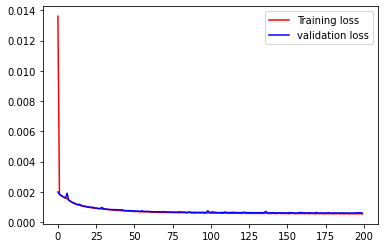

In [48]:
history2=autoencoder2.fit(train_intermediate,train,epochs=200,batch_size=5,validation_split=0.1,callbacks=[checkpoint2])

plt.plot(history2.history['loss'],'r',label='Training loss')
plt.plot(history2.history['val_loss'],'b',label='validation loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


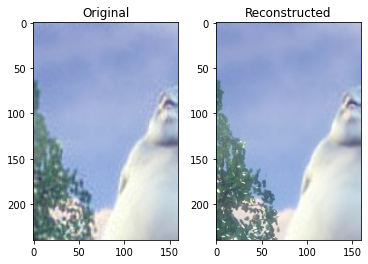

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------ 0.9557344509919469


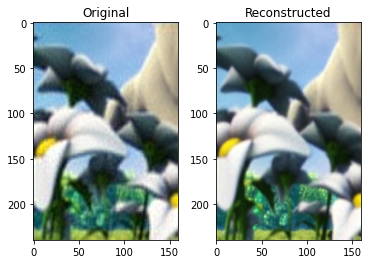

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------ 0.9608955614916633


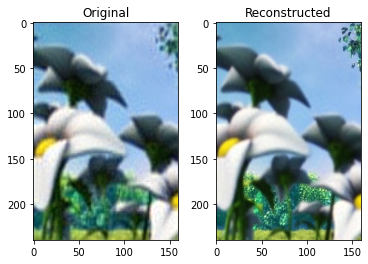

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------ 0.9353410330085893


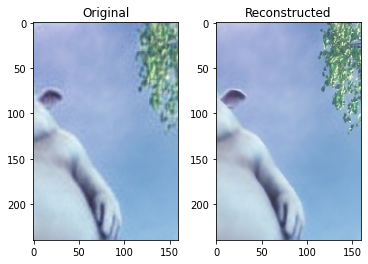

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------ 0.9594346007300555


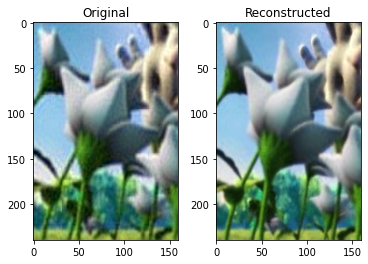

------------------------------ 0.9532348213935661


In [51]:
# autoencoder2.load_weights(filepath2)

num = random.sample(range(0,len(train_intermediate)),5)

for i in num:
    im = train_intermediate[i]
    pred=autoencoder2.predict(np.expand_dims(im,axis=0))
    plt.subplot(121)
    plt.imshow(im)
    plt.title('Original')
    
    plt.subplot(122)
    plt.imshow(pred[0,:,:,:])
    plt.title('Reconstructed')
    
    plt.show()
    
    print('-'*30,overall_ssim(train_intermediate[i],pred[0,:,:,:]))

In [56]:
autoencoder1.load_weights(filepath1)
test_intermediate = autoencoder1.predict(test)
test_preds = autoencoder2.predict(test_intermediate)

overall_ssim(test,test_preds)

0.9533856244860482

In [57]:
import gc
pred = []
for i in range(len(images)):
    if i%10 == 0:
        print(i)
    imgs_new = np.expand_dims(images[i],axis=0)
    preds=autoencoder2.predict(autoencoder1.predict(imgs_new))
    pred.append(preds)
    del(preds)
#     del(code)
    del(imgs_new)
    gc.collect()
    
pred1=np.array(pred)
pred1=pred1.reshape(pred1.shape[0],pred1.shape[2],pred1.shape[3],pred1.shape[4])
pred2 = pred1 * 255.

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470


In [58]:
overall_ssim(images,pred1)

0.9590757492372184

In [59]:
names1=[]
images1=[]
for i in range(len(pred2)):
    cv2.imwrite('frame_{}.jpg'.format(i),pred2[i])
    
for i in range(len(pred2)):
    ims = cv2.imread('frame_{}.jpg'.format(i))
    name = 'frame_{}.jpg'.format(i)
    names1.append(name)
    images1.append(ims)

In [60]:
count=0
for i in range(0,len(images1)-1,2):
    x1 = cv2.imread(names1[i])
    x2 = cv2.imread(names1[i+1])
    x3 = cv2.hconcat([x1,x2])
    try:
        os.remove(names1[i])
        os.remove(names1[i+1])
    except IndexError:
        print(i)
        break
    cv2.imwrite('frame_{}.jpg'.format(count),x3)
    count+=1

In [62]:
video = cv2.VideoWriter('recon3.avi', 0 , 25.0, (320,240))
for image in names1:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

In [ ]:
inp = Input((480,320,3))
code = encoder(inp)
reconstruction = decoder(code)
model = Model(inp,reconstruction)
model.compile(optimizer='adam',loss='mse',metrics=['mae'])
model.summary()

In [ ]:
filepath = 'weights_32_res.hdf5'
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',verbose=0,save_best_only=True,mode=min)

history=autoencoder.fit(train,train,epochs=50,batch_size=5,validation_split=0.1,callbacks=[checkpoint])

plt.plot(history.history['loss'],'r',label='Training loss')
plt.plot(history.history['val_loss'],'b',label='validation loss')
plt.legend()
plt.show()

In [ ]:
autoencoder.load_weights(filepath)

num = random.sample(range(0,len(test)),5)

for i in num:
    im = test[i]
    pred=autoencoder.predict(np.expand_dims(im,axis=0))
    plt.subplot(121)
    plt.imshow(im)
    plt.title('Original')
    
    plt.subplot(122)
    plt.imshow(pred[0,:,:,:])
    plt.title('Reconstructed')
    
    plt.show()

In [ ]:
predicted=autoencoder.predict(test)
overall_ssim(test,predicted)

In [ ]:
import gc
pred = []
for i in range(len(images)):
    if i%10 == 0:
        print(i)
    imgs_new = np.expand_dims(images[i],axis=0)
    preds=autoencoder.predict(imgs_new)
    pred.append(preds)
    del(preds)
#     del(code)
    del(imgs_new)
    gc.collect()
    
pred1=np.array(pred)
pred1=pred1.reshape(pred1.shape[0],pred1.shape[2],pred1.shape[3],pred1.shape[4])
pred2 = pred1 * 255.

In [ ]:
overall_ssim(images,pred1)

In [ ]:
names1=[]
images1=[]
for i in range(len(pred2)):
    cv2.imwrite('frame_{}.jpg'.format(i),pred2[i])
    
for i in range(len(pred2)):
    ims = cv2.imread('frame_{}.jpg'.format(i))
    name = 'frame_{}.jpg'.format(i)
    names1.append(name)
    images1.append(ims)

In [ ]:
count=0
for i in range(0,len(images1)-1,2):
    x1 = cv2.imread(names1[i])
    x2 = cv2.imread(names1[i+1])
    x3 = cv2.hconcat([x1,x2])
    try:
        os.remove(names1[i])
        os.remove(names1[i+1])
    except IndexError:
        print(i)
        break
    cv2.imwrite('frame_{}.jpg'.format(count),x3)
    count+=1

In [ ]:
video = cv2.VideoWriter('recon1.avi', 0 , 25.0, (640,480))
for image in names1:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

In [ ]:
model.load_weights(filepath)

num_test = random.sample(range(0,len(test)),5)
for i in num_test:
    img = test[i]
    visualize(img,encoder,decoder)

In [ ]:
bottle = encoder.predict(test)
predicted = decoder.predict(bottle)
overall_ssim(test,predicted)

In [ ]:
import gc
pred = []
for i in range(len(images)):
    if i%10 == 0:
        print(i)
    imgs_new = np.expand_dims(images[i],axis=0)
    code = encoder.predict(imgs_new)
    preds = decoder.predict(code)
    pred.append(preds)
    del(preds)
    del(code)
    del(imgs_new)
    gc.collect()
    
pred1=np.array(pred)
pred1=pred1.reshape(pred1.shape[0],pred1.shape[2],pred1.shape[3],pred1.shape[4])
pred2 = pred1 * 255.

In [ ]:
pred1.shape

In [ ]:
overall_ssim(images,pred1)

In [ ]:
p = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\ReconVideo_Frames'
p = p.replace('\\','/')

In [ ]:
p1=os.getcwd()
os.chdir(p)
os.getcwd()

In [ ]:
names1=[]
images1=[]
for i in range(len(pred2)):
    cv2.imwrite('frame_{}.jpg'.format(i),pred2[i])
    
for i in range(len(pred2)):
    ims = cv2.imread('frame_{}.jpg'.format(i))
    name = 'frame_{}.jpg'.format(i)
    names1.append(name)
    images1.append(ims)

In [ ]:
video = cv2.VideoWriter('recon.avi', 0 , 25.0, (320,480))
for image in names1:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

In [ ]:
x1 = cv2.imread(names1[0])
x2 = cv2.imread(names1[1])
x3 = cv2.imread(names1[2])
x4 = cv2.imread(names1[3])

plt.subplot(141)
plt.imshow(x1)

plt.subplot(142)
plt.imshow(x2)

plt.subplot(143)
plt.imshow(x3)

plt.subplot(144)
plt.imshow(x4)

In [ ]:
x_1 = cv2.hconcat([x1,x2])
plt.imshow(x_1)

In [ ]:
os.getcwd()

In [ ]:
count=0
for i in range(0,len(images1)-1,2):
    x1 = cv2.imread(names1[i])
    x2 = cv2.imread(names1[i+1])
    x3 = cv2.hconcat([x1,x2])
    try:
        os.remove(names1[i])
        os.remove(names1[i+1])
    except IndexError:
        print(i)
        break
    cv2.imwrite('frame_{}.jpg'.format(count),x3)
    count+=1

In [ ]:
video = cv2.VideoWriter('recon.avi', 0 , 25.0, (640,480))
for image in names1:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

In [ ]:
os.chdir('C:/Users/Saad.LAKES/Desktop/Autoencoders/Videos/Results/Video_Frames')

In [ ]:
video1 = cv2.VideoWriter('original.avi', 0 , 25.0, (640,480))
for image in names:
    video1.write(cv2.imread(image))
cv2.destroyAllWindows()
video1.release()

In [ ]:
plt.imshow(images1[0])

In [ ]:
plt.subplot(141)
plt.imshow(imCrop(images[1],2)[0])
plt.subplot(142)
plt.imshow(imCrop(images[1],2)[1])
# plt.subplot(143)
# plt.imshow(imCrop(images[1],4)[2])
# plt.subplot(144)
# plt.imshow(imCrop(images[1],4)[3])

In [ ]:
images[1].shape

In [ ]:
images[1][540,480]

In [ ]:
x=image_slicer.slice('frame_1.jpg',16,save=False)

In [ ]:
from PIL import ImageDraw, ImageFont

In [ ]:
for tile in x:
    overlay = ImageDraw.Draw(tile.image)

In [ ]:
overlay

In [ ]:
np.asarray(x[1].image)

In [ ]:
# filterss = 16
# SSIM =0.90
# # The encoder
# encoder = Sequential()
# encoder.add(InputLayer((480,320,3)))
# encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))
# encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))
# encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))
# encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))


# # The decoder
# decoder = Sequential()
# decoder.add(InputLayer((30,20,filterss)))
# decoder.add(Conv2DTranspose(filters=filterss,kernel_size=3,strides=2,padding='same'))
# decoder.add(Conv2DTranspose(filters=filterss,kernel_size=3,strides=2,padding='same'))
# decoder.add(Conv2DTranspose(filters=filterss,kernel_size=3,strides=2,padding='same'))
# decoder.add(Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same'))